## Step 1

Assign the constants with user defined values.
- **ACCESS_TOKEN**: Github token to use github API
- **REPO**: Name of github repository
- **limit_pr**: Limit the number of closed PR to use
- **open_pr_id**: Open PR ID to get recommendation
- **similarity_threshold**: Threshold to use top similar PRs

It will fetch the closed PRs required.

In [1]:
from github import Github
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

ACCESS_TOKEN = '5feeb874084cea318f3c5cbf56b70bce1a578290'
REPO = 'sveltejs/svelte'
limit_pr = 500
open_pr_id = 1410

# Get the access to Github API
client = Github(ACCESS_TOKEN, per_page=300)

# Get the repository object from Github API
repo = client.get_repo(REPO)

# Get the maintainer of the repo
repo_maintainer = repo.full_name.split("/")[0]

# Get all the closed pull requests
closed_prs = list(repo.get_pulls(state='closed'))

# Limit number of pull requests if limit_pr is set
if limit_pr != None:
    closed_prs = closed_prs[:limit_pr]

## Step 2

Collect the necessary closed pull requests data from the repository using github api.
Store the data in variables for further usage to prevent github api request rate limit.
Build a bipartite graph using the data of open PRs and respective reviewers.

In [2]:
# Initialize a graph
graphz = nx.Graph()

# It inserts all the reviewers node we add to graph
closed_prs_reviewers = []

# Save the data loaded from API for future use
closed_prs_meta = []

# Iterate through all the closed pull requests
for pr in closed_prs:

    # If PR doesnt have comments continue with next
    if pr.get_issue_comments().totalCount == 0:
        continue

    # Get the user who submitted this PR
    pull_requester = pr.user.login

    # Get the PR number
    pr_number = 'PR #' + str(pr.number)

    ## Insert PR into graph node
    graphz.add_node(pr_number, type='Pull Request', bipartite=0)

    # Get all the comments of the PR
    comments = pr.get_issue_comments()

    # Get the meta data from PR and insert in closed_prs_meta
    pr_data = {}
    pr_data['id'] = pr_number
    pr_data['title'] = pr.title
    pr_data['body'] = pr.body
    pr_data['comments'] = comments
    closed_prs_meta.append(pr_data)

    # Iterate through all the comments
    for comment in comments:

        # Exclude user who are bots, maintainer, or PR submitter
        if comment.user != None and 'bot' not in comment.user.login and repo_maintainer != comment.user.login and pull_requester != comment.user.login:

            # Get the reviewer from comment
            reviewer = comment.user.login

            # Insert reviewer into graph node and closed_prs_reviewers list
            if reviewer not in closed_prs_reviewers:
                closed_prs_reviewers.append(reviewer)
                graphz.add_node(reviewer, type='user', bipartite=1)

            # If there is occurence of multiple comment, then add the occurence to the edge weight
            if graphz.has_edge(reviewer, pr_number):
                new_weight = graphz.get_edge_data(
                    reviewer, pr_number)['weight'] + 1
                graphz[reviewer][pr_number]['weight'] = new_weight
            else:
                graphz.add_edge(reviewer, pr_number,
                                weight=1, type='reviews')

## Step 3
Visualize the bipartite graph where blue nodes are closed PRs and red nodes are reviewers.

C:\Users\sytechno\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


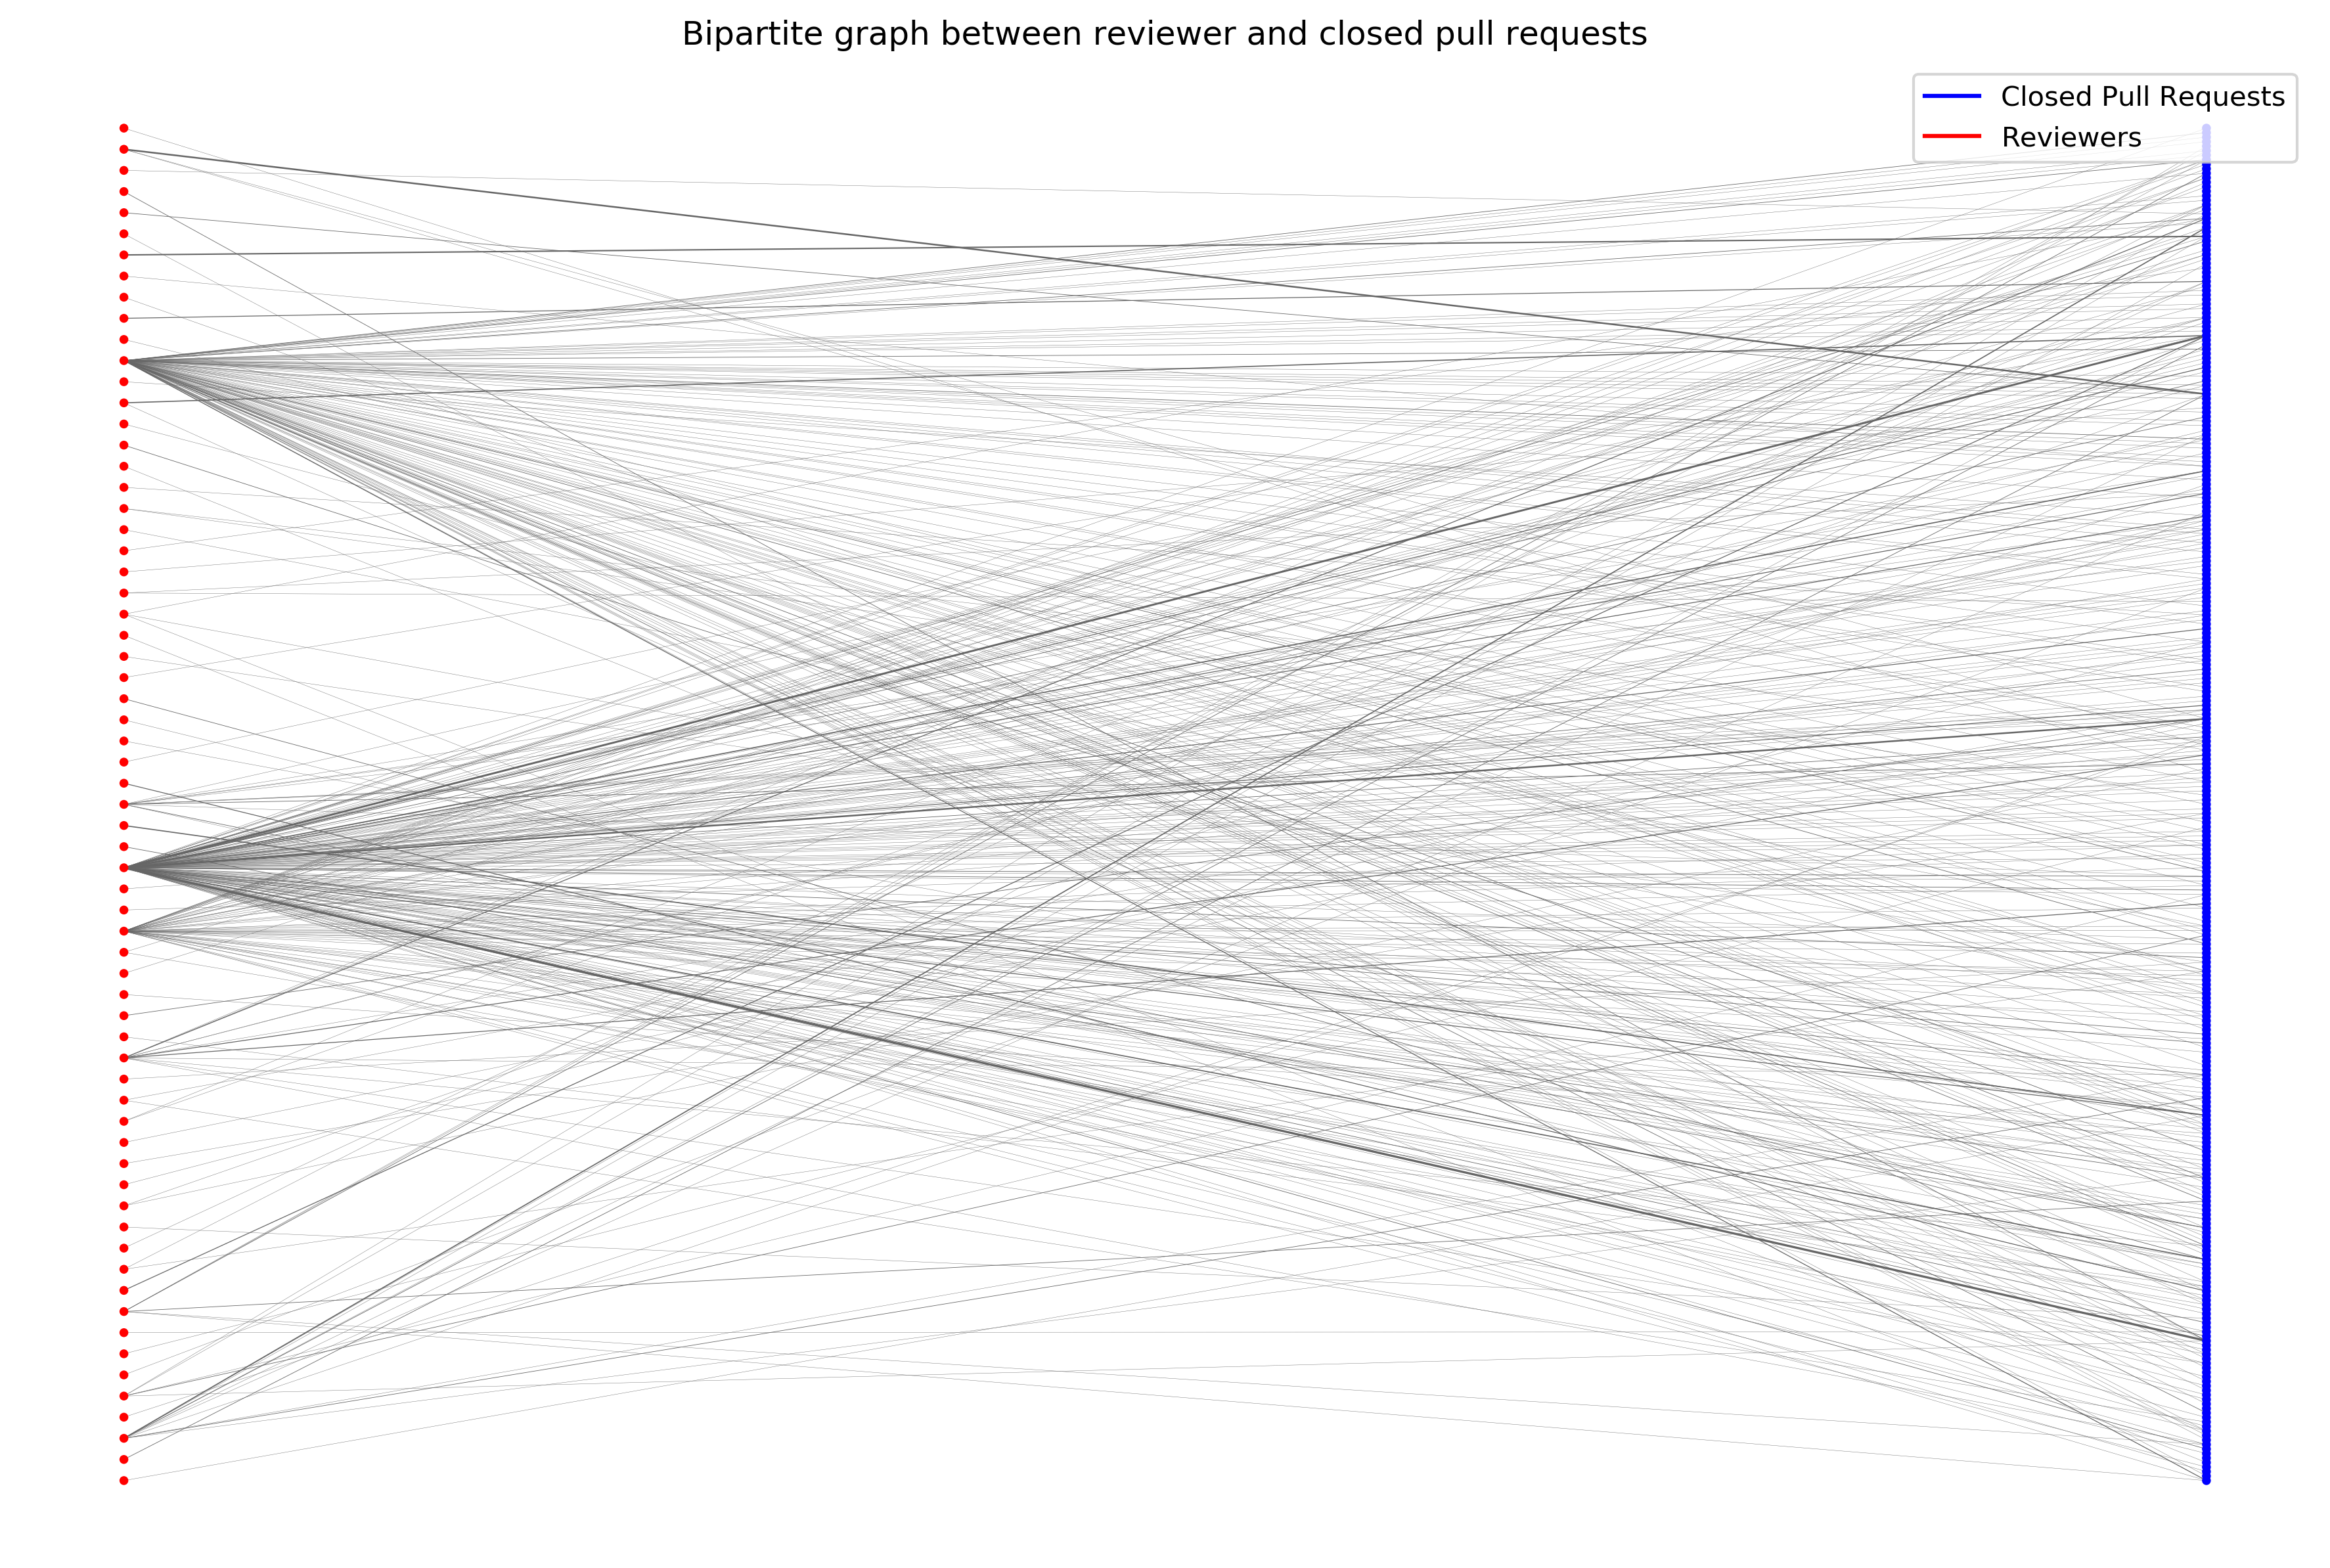

In [3]:
plt.figure(figsize=(15, 10), dpi=300)
plt.rcParams['legend.loc'] = 'upper right'

pos = nx.bipartite_layout(graphz, closed_prs_reviewers)

node_colors = [ 'blue' for node in graphz.nodes()]
for i, node in enumerate(graphz.nodes):
    color = 'blue'
    if node in closed_prs_reviewers:
        color = "red"
    node_colors[i] = color

plt.axis('off')
plt.title("Bipartite graph between reviewer and closed pull requests")
plt.plot([0],[0], color="blue", label='Closed Pull Requests')
plt.plot([0],[0], color="red", label='Reviewers')
plt.legend()

edges = graphz.edges()
weights = [graphz[u][v]['weight']/10 for u,v in edges]

nx.draw_networkx(graphz, pos=pos, node_size=5, node_color=node_colors,
                with_labels=False, width=weights, font_size=6, edge_color="#666666")

figname = 'bipartite_graph'
plt.savefig(figname+'.png', bbox_inches='tight', dpi=500)
plt.show()

## Step 4

Get the information about the bipartite graph

In [4]:
print(nx.info(graphz))
print("Number of reviewers", len(closed_prs_reviewers))

Name: 
Type: Graph
Number of nodes: 366
Number of edges: 404
Average degree:   2.2077
Number of reviewers 65


## Step 5

Build a document corpus for all the closed PRs

In [54]:
import re

# Generate document corpus for closed pull requests
closed_prs_corpus = {}
for pr in closed_prs_meta:
    title = str(pr['title'])
    body = str(pr['body'])
    doc = title + " " + body
    for comment in pr['comments']:
        doc += comment.body
    
    # Remove the code, mentions and URLS
    doc = re.sub('`.*`', '', doc)
    doc = re.sub(r"(?:\@|#|https?\://)\S+", "", doc)
    # insert document into corpus with index of corpus id
    closed_prs_corpus[pr['id']] = doc

## Step 6

Get the open pull request and build a document corpus for it.

In [6]:
# Get the list of closed PRS
open_prs = list(repo.get_pulls(state='open', sort='created'))
if len(open_prs) == 0:
    raise Exception("No open PRs found")

# Get the first open PR
open_pr = open_prs[0]

# If Id is provided in function, choose this one
if open_pr_id != None:
    for pr in open_prs:
        if open_pr_id == pr.number:
            open_pr = pr

# Get corpus document for open PR
open_pr_corpus = str(open_pr.title) + "\n" + str(open_pr.body)
for comment in open_pr.get_issue_comments():
    open_pr_corpus += comment.body

# Remove the code, mentions and URLS
open_pr_corpus = re.sub('`.*`', '', open_pr_corpus)
open_pr_corpus = re.sub(r"(?:\@|#|https?\://)\S+", "", open_pr_corpus)

## Step 7

Show the current reviewers in the open PR

In [7]:
# Get the open PR submitter
open_pr_requester = open_pr.user.login

# Get the actual reviewers of open PR
open_pr_reviewers = []
for comment in open_pr.get_issue_comments():
    reviewer = comment.user.login
    # Exclude bot, maintainer and PR submitter
    if open_pr_requester != reviewer and reviewer not in open_pr_reviewers and 'bot' not in reviewer and repo_maintainer != reviewer:
        open_pr_reviewers.append(reviewer)

# Remove the open PR reviewers that are not in our graph
for open_pr_rv in open_pr_reviewers:
    if open_pr_rv not in closed_prs_reviewers:
        open_pr_reviewers.remove(open_pr_rv)
        
print(open_pr_reviewers)

['stalkerg', 'antony', 'Conduitry']


## Step 8

Define the cosine similarity functions with helper function for topic modeling.

In [11]:
import networkx as nx
import nltk
import numpy as np
from gensim import corpora, models, similarities
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from github import Github
from networkx.algorithms import bipartite
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.stem.porter import *
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
np.random.seed(2018)
nltk.download('wordnet')
stemmer = nltk.stem.porter.PorterStemmer()

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(stemmer.stem(
                WordNetLemmatizer().lemmatize(token, pos='v')))
    return result


def lda_cosine_sim(closed_prs_meta, closed_prs_corpus, open_pr_corpus):
    
    corpus_data = []
    
    # preprocess each of documents and insert in corpus data
    for i, pr in enumerate(closed_prs_meta):
        preprocessed_data = preprocess(closed_prs_corpus[pr['id']])
        corpus_data.append(preprocessed_data)
    # Also, add preprocessed open PR document to end of corpus data
    corpus_data.append(preprocess(open_pr_corpus))
    
    # Map between normalized words and integer ID in dictionary
    dictionary = gensim.corpora.Dictionary(corpus_data)
    
    # FIlter the dictionary items
    dictionary.filter_extremes(no_below=15, no_above=0.8, keep_n=100000)
    
    # Convert the documents into bag of words format
    bow_corpus = [dictionary.doc2bow(doc) for doc in corpus_data]
    
    # Apply TF-IDF in bag of words
    tfidf = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]
    
    # Apply LDA to TF_IDF corpus
    lda_model_tfidf = gensim.models.LdaMulticore(
        corpus_tfidf, num_topics=100, id2word=dictionary, passes=2, workers=4)
    
    # Compare the open PR and closed PRs documents corpus to get cosine similarity
    similarity_matrix = []
    for i in range(len(corpus_data) - 1):
        sim = gensim.matutils.cossim(
            lda_model_tfidf[bow_corpus][i], lda_model_tfidf[bow_corpus][len(corpus_data) - 1])
        similarity_matrix.append(sim)
    return similarity_matrix

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sytechno\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Step 9

Get similarity matrix result from lda cosine similarity function passing the corpus document of all closed PRs and one open PR

Get the similarity matrix result as defined by similarity threshold

Print top 5 similarity matrix result

In [13]:
import itertools
import gensim

# Set similarity threshold
similarity_threshold = 0.2

# Get the similarity matrix between all the closed PRs and open PR
similarity_matrix = lda_cosine_sim(closed_prs_meta, closed_prs_corpus, open_pr_corpus)

# Sort the similarity matrix in reverse order
similarity_matrix = sorted(similarity_matrix, reverse=True)

# Get the top similarity matrix greater than similarity threshold
top_similarity_matrix = {}
for i, pr in enumerate(closed_prs_meta):
    top_similarity_matrix[pr['id']] = similarity_matrix[i]
    
# Get top similarity matrix using similarity threshold value
top_similarity_matrix = dict(itertools.islice(top_similarity_matrix.items(), int(len(top_similarity_matrix)*similarity_threshold)))

# print number of PR choosen
print("Number of closed PR selected: ", len(top_similarity_matrix))

# Print top 5 PRs with similarity score
print("####Similarity score of pull requests ####")
show_5_similarity_matrix = dict(itertools.islice(top_similarity_matrix.items(),5))
for key in show_5_similarity_matrix:
        print("{0} {1} {2}".format(key, 'PR #' + str(open_pr.number), top_similarity_matrix[key]))

Number of closed PR selected:  266
####Similarity score of pull requests ####
PR #4758 PR #1410 0.9772829979612468
PR #4753 PR #1410 0.969290470128525
PR #4750 PR #1410 0.9680103951840777
PR #4739 PR #1410 0.9651256428764846
PR #4733 PR #1410 0.9649319481229792


## Step 10

Define custom weight for bipartite graph projection. It uses weights from bipartite graph and similarity score to calculate new weights.

Remove unwanted PRs nodes from bipartite graph to form a bipartite subgraph.

Project the bipartite subgraph to build a reviewer's only graph.

Then remove isolated reviewer nodes.

In [29]:
def custom_weight(G, u, v, weight='weight'):
    weight_val = 0
    for nbr in set(G[u]) & set(G[v]):
        weight_val += (G[u][nbr]['weight'] + G[v][nbr]['weight'])*G.nodes[nbr]['similarity']
    return weight_val


# Copy the bipartite graph into new onw
copied_barpartite_graphz = graphz.copy()

# Get the top PR from similarity rank
pr_nodes = []
for similarity_id in top_similarity_matrix:
    pr_nodes.append(similarity_id)

# Remove PR nodes other than top selected PR nodes
for node in list(copied_barpartite_graphz.nodes):
    if 'PR #' in node and node not in pr_nodes and copied_barpartite_graphz.has_node(node):
        copied_barpartite_graphz.remove_node(node)

# Insert similarity scores in PR nodes for further use in custom weight
for node in copied_barpartite_graphz.nodes:
    if node in pr_nodes:
        copied_barpartite_graphz.nodes[node]['similarity'] = top_similarity_matrix[node]

# Initialize a projected graph
projected_graphz = nx.Graph()

# Project the copied bipartate graph into reviewers graph considering the weights
projected_graphz = bipartite.generic_weighted_projected_graph(
    copied_barpartite_graphz, closed_prs_reviewers, weight_function=custom_weight)

# Remove isolatated nodes from the projected graph
for node in list(nx.isolates(projected_graphz)):
    projected_graphz.remove_node(node)

## Step 11

Visualize the projected reviewer's only graph

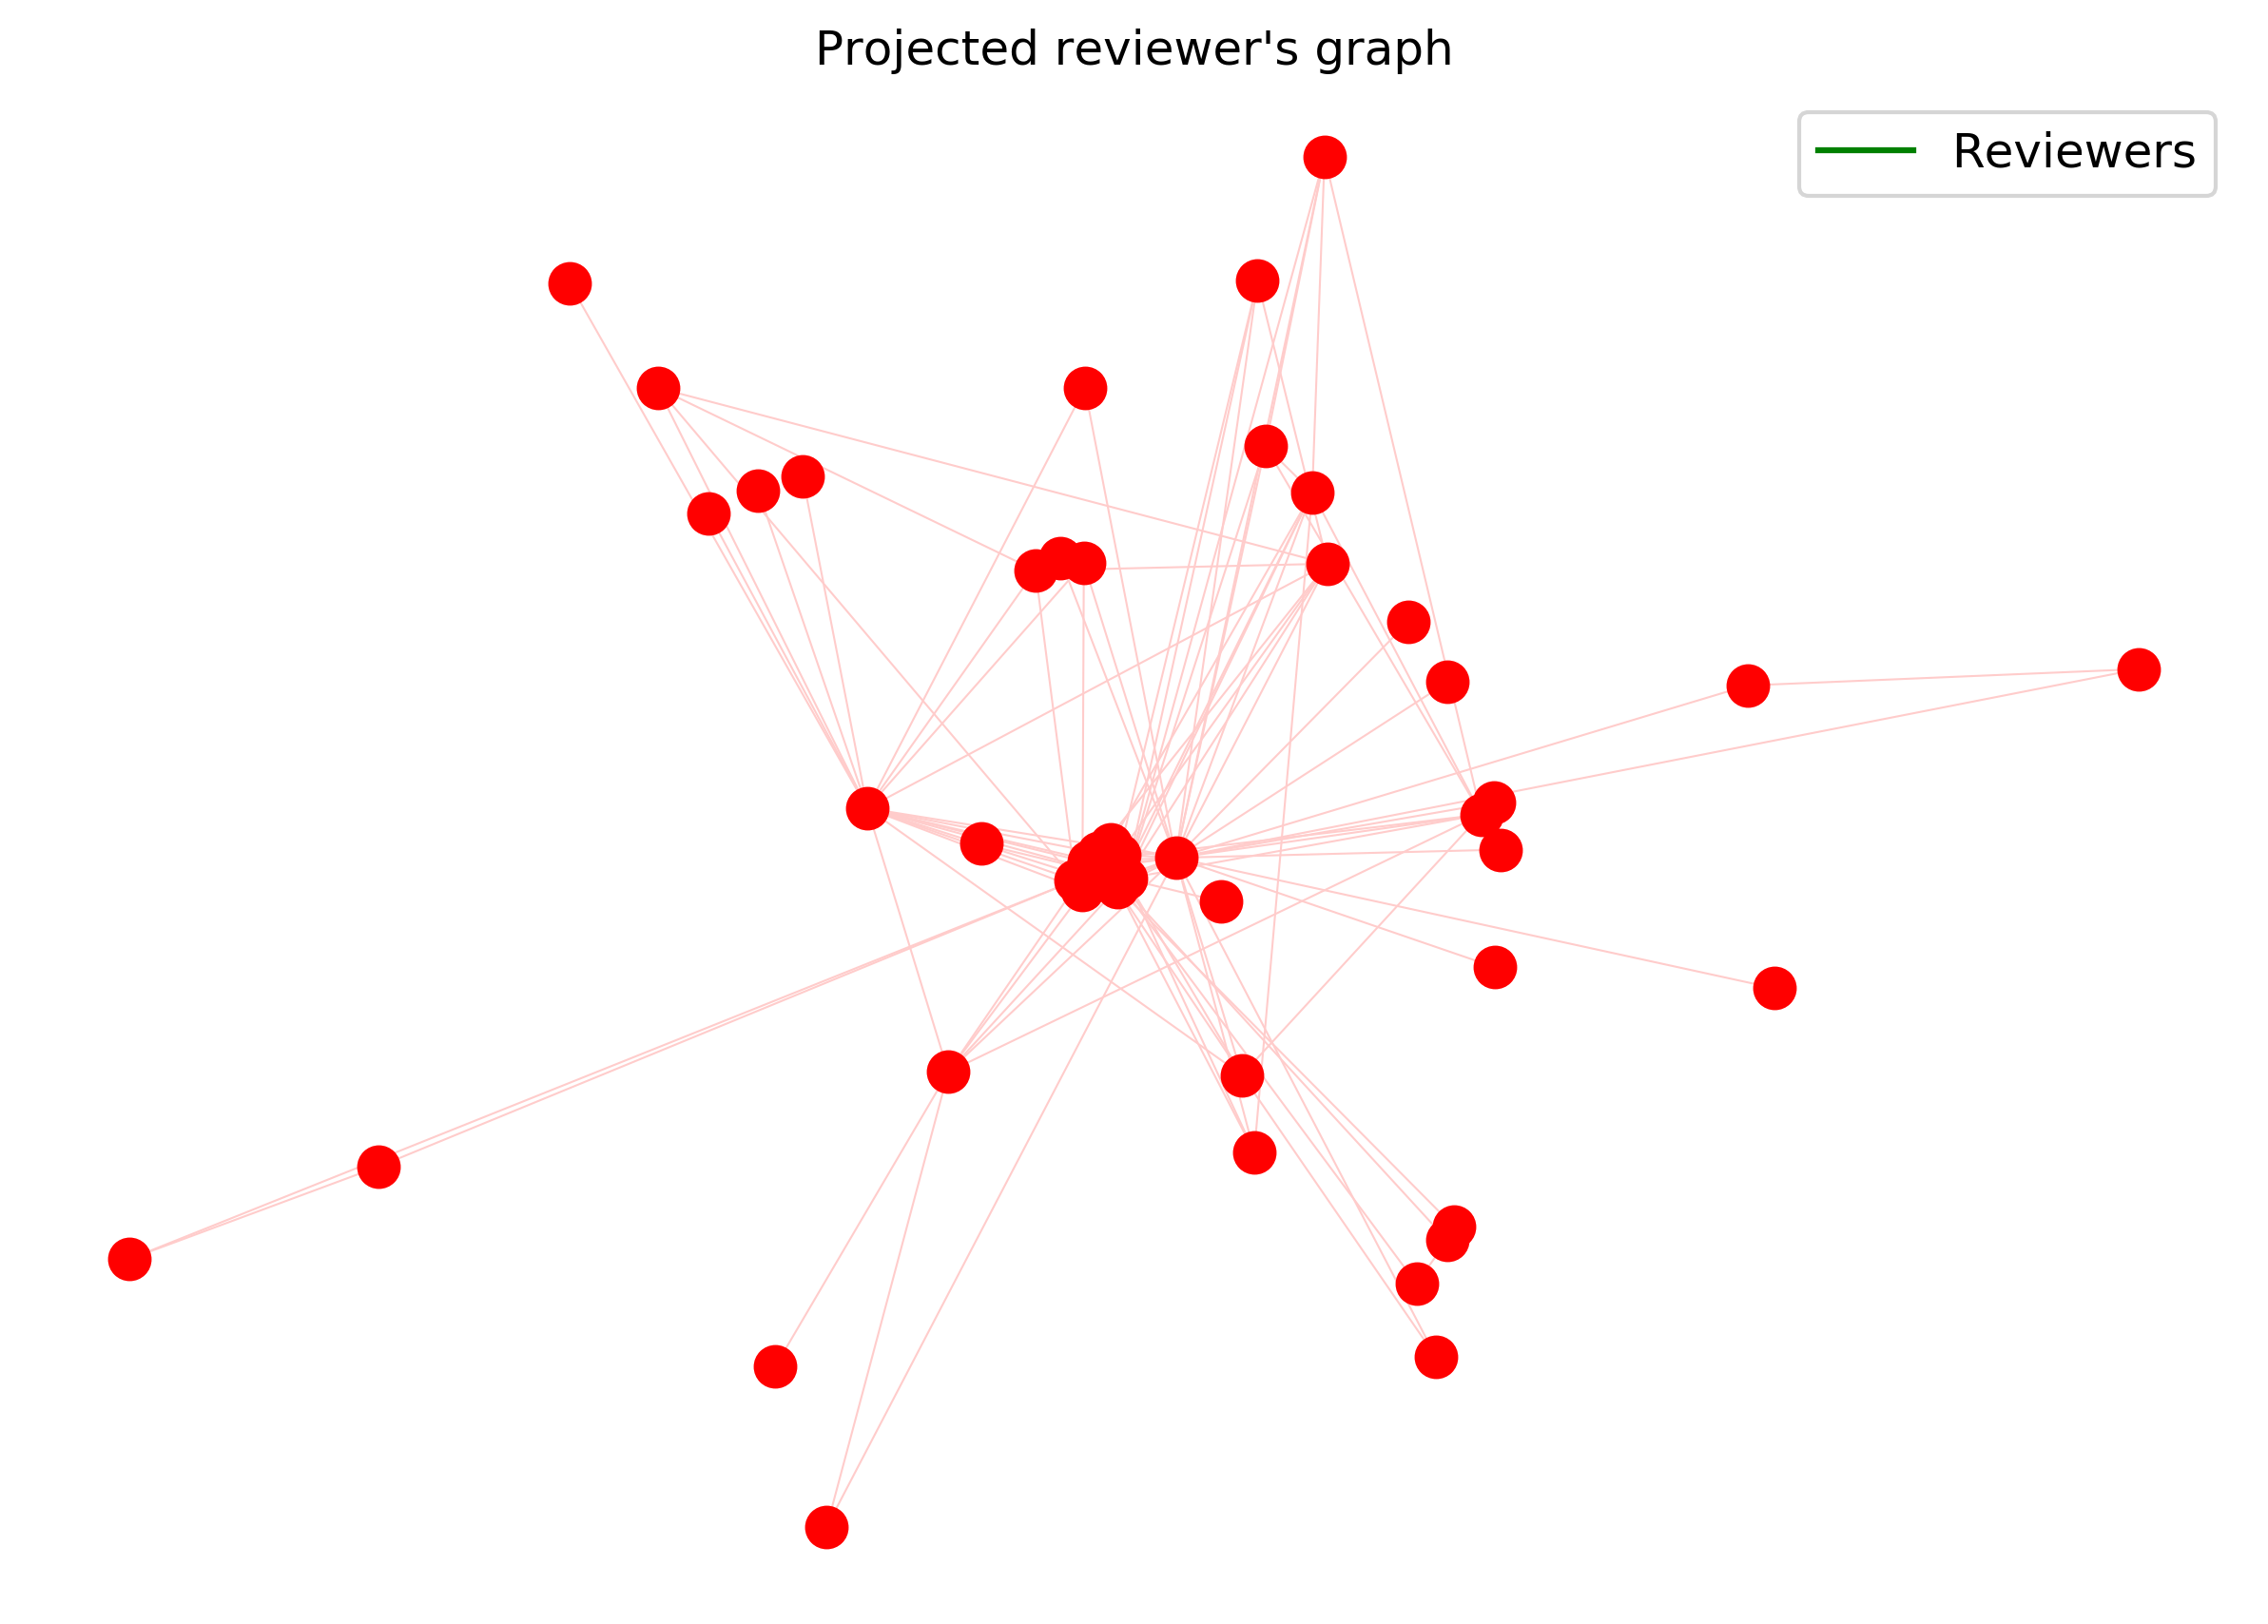

In [45]:
pos = nx.kamada_kawai_layout(graphz, weight='weight')
plt.figure(figsize=(10, 7), dpi=300)
plt.rcParams['legend.loc'] = 'upper right'

plt.plot([0],[0], color="green", label='Reviewers')
plt.legend()

nx.draw_networkx(projected_graphz, pos=pos, node_size=100, node_color="red",
                 with_labels=False, width=0.5, edge_color="#ffcccb")

figname = 'projected_graph'
plt.title("Projected reviewer's graph")
plt.savefig(figname+'.png', bbox_inches='tight', dpi=500)
plt.axis('off')
plt.show()

# save gephi graph file for visualization
# nx.write_gexf(projected_graphz, "projected_graph.gexf")

## Step 12

Show the information of reviewer's graph

In [17]:
print(nx.info(projected_graphz))
print("Average clustering:", nx.average_clustering(projected_graphz))

Name: 
Type: Graph
Number of nodes: 49
Number of edges: 98
Average degree:   4.0000
Average clustering: 0.5692226756569642


## Step 13

Apply page rank algorithm and display the results

The reviewer results are the recommended reviewers 

In [18]:
# Number of recommendation results to show
limit_recomm = 5

# Run page rank algorithm in projected graph
pagerank = nx.pagerank(projected_graphz, alpha=0.85, personalization=None, max_iter=100, tol=1e-06,
                       nstart=None, weight='weight', dangling=None)
# Sort the page rank result by score
pagerank = list(sorted(pagerank.items(), reverse=True, key=lambda x: x[1]))

# If there is recommendation limitation, limit it
if limit_recomm != None:
    pagerank = pagerank[:limit_recomm]

# Get only users from page rank result
pagerank_reviewers = [pg[0] for pg in pagerank]

# Print page rank scores
print("Page rank scores")
print(pagerank)

# Print the current reviewers
print("Current reviewers")
print(open_pr_reviewers)

# Print the recommended reviewers
print("Recommended Reviewers")
print(pagerank_reviewers)

Page rank scores
[('Conduitry', 0.2035194586743017), ('Rich-Harris', 0.104095764842048), ('codecov-io', 0.058312186437871165), ('antony', 0.03983219824348161), ('rixo', 0.03710943583377977)]
Current reviewers
['stalkerg', 'antony', 'Conduitry']
Recommended Reviewers
['Conduitry', 'Rich-Harris', 'codecov-io', 'antony', 'rixo']


## Step 14

Show the accuracy results
Also, show confusion matrix and other metrics like precision, recall, and f1-score

In [19]:
from sklearn.metrics import *

page_rank_result = []

# Get the predicted reviewers
for opr_reviewer in open_pr_reviewers:
    if opr_reviewer in pagerank_reviewers:
        page_rank_result.append(opr_reviewer)
    else:
        page_rank_result.append("")

# Define true and predicted reviewers to getr accuracy
y_true = np.array(open_pr_reviewers)
y_pred = np.array(page_rank_result)

#  Get the accuracy score
x_accuracy = accuracy_score(y_true, y_pred)

# Print the accuracy result
print("Accuracy:", x_accuracy)

x_confusion_matrix = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print("Confusion Matrix")
print(x_confusion_matrix)

# Get full report different metrices
report = classification_report(y_true, y_pred)
print(report)

Accuracy: 0.6666666666666666
Confusion Matrix
[[0 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [1 0 0 0]]
              precision    recall  f1-score   support

                   0.00      0.00      0.00         0
   Conduitry       1.00      1.00      1.00         1
      antony       1.00      1.00      1.00         1
    stalkerg       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.50      0.50      0.50         3
weighted avg       0.67      0.67      0.67         3



C:\Users\sytechno\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sytechno\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Step 15

Generate a accuracy result for random 3 open PRs of the given repository

In [23]:
# Adjust similarity threshold
similarity_threshold = 0.2

# Get 3 open PR Ids
three_open_prs = [4309, 4559, 4296]

# Store the filtered open PRs here
open_pull_requests = []

# Iterate through all the open pull requests
for opq in open_prs:
    
    # Continue if not in the list
    if opq.number not in three_open_prs: continue 
    
    # If open PR has comments less than 2 comments, discard it
    if opq.get_issue_comments().totalCount < 2:
        print(opq.number)
        raise Exception("Use open PR with comments greater than 2")
    
    # Build a document corpus for the PR
    open_pr_doc = str(opq.title) + "\n" + str(opq.body)

    opq_requester = opq.user.login
    open_pr_reviewers = []
    for comment in opq.get_issue_comments():
        open_pr_doc += comment.body
        reviewer = comment.user.login
        if opq_requester != reviewer and reviewer not in open_pr_reviewers and 'bot' not in reviewer:
            open_pr_reviewers.append(reviewer)
    
    # Remove the code, mentions and URLS
    open_pr_doc = re.sub(r"\```[^```]*\```", "", open_pr_doc)
    open_pr_doc = re.sub(r"(?:\@|#|https?\://)\S+", "", open_pr_doc)
    
    # Get the reviewers of the open PR
    for new_rev in list(open_pr_reviewers):
        if new_rev not in closed_prs_reviewers:
            open_pr_reviewers.remove(new_rev)
    
    # Append the filtered PR data
    open_pull_requests.append((opq.number, open_pr_doc, open_pr_reviewers))

# Iterate through filtered open PRs and measure accuracy
pr_metrices = []
for opqid, open_pr_doc, open_pr_reviewers in open_pull_requests:
    
    # Get the similarity matrix between all the closed PRs and open PR
    similarity_matrix = lda_cosine_sim(closed_prs_meta, closed_prs_corpus, open_pr_doc)
    
    # Sort the similarity matrix in reverse order
    similarity_matrix = sorted(similarity_matrix, reverse=True)
    
    # Get the top similarity matrix by PR and filter with threshold
    top_similarity_matrix = {}
    for i, pr in enumerate(closed_prs_meta):
        top_similarity_matrix[pr['id']] = similarity_matrix[i]

    # Get top similarity matrix using similarity threshold value
    top_similarity_matrix = dict(itertools.islice(top_similarity_matrix.items(), int(len(top_similarity_matrix)*similarity_threshold)))
    
    # Copy the bipartite graph into new one
    copied_barpartite_graphz = graphz.copy()

    # Get the top PR from similarity rank
    pr_nodes = []
    for similarity_id in top_similarity_matrix:
        pr_nodes.append(similarity_id)
    
    # Remove PR nodes other than top selected PR nodes
    for node in list(copied_barpartite_graphz.nodes):
        if 'PR #' in node and node not in pr_nodes and copied_barpartite_graphz.has_node(node):
            copied_barpartite_graphz.remove_node(node)
            
    # Insert similarity scores in PR nodes for further use in custom weight
    for node in copied_barpartite_graphz.nodes:
        if node in pr_nodes:
            copied_barpartite_graphz.nodes[node]['similarity'] = top_similarity_matrix[node]

    # Initialize a projected graph
    projected_graphz = nx.Graph()

    # Project the copied bipartate graph into reviewers graph considering the weights
    projected_graphz = bipartite.generic_weighted_projected_graph(
        copied_barpartite_graphz, closed_prs_reviewers, weight_function=custom_weight)

    # Remove isolatated nodes from the projected graph
    for node in list(nx.isolates(projected_graphz)):
        projected_graphz.remove_node(node)

    # Run page rank algorithm in projected graph
    pagerank = nx.pagerank(projected_graphz, alpha=0.85, personalization=None, max_iter=100, tol=1e-06,
                           nstart=None, weight='weight', dangling=None)
    
    # get the accuracy from page rank results
    page_rank_metrics = []
    
    # Iterate through number of recommendations
    for i in range(1, 6):
        
        # sort the page rank result
        pagerank_sorted = sorted(pagerank.items(), reverse=True, key=lambda x: x[1])
        
        # Get only reviewers name from pagerank result
        pagerank_reviewers = [pg[0] for pg in pagerank_sorted][:i]
        
        # Get the predicted reviewers
        page_rank_result = []
        for opr_reviewer in open_pr_reviewers:
            if opr_reviewer in pagerank_reviewers:
                page_rank_result.append(opr_reviewer)
            else:
                page_rank_result.append("")
        
        # Define true and predicted values for finding accuracy
        pg_y_true = np.array(open_pr_reviewers)
        pg_y_pred = np.array(page_rank_result)
        
        # Get the accuracy score
        pg_accuracy = accuracy_score(pg_y_true, pg_y_pred)
        
        # Append the accuracy socre to main list
        page_rank_metrics.append(pg_accuracy)
    
    # Append into whole result
    pr_metrices.append(page_rank_metrics)

## Step 16

Plot the accuracy result

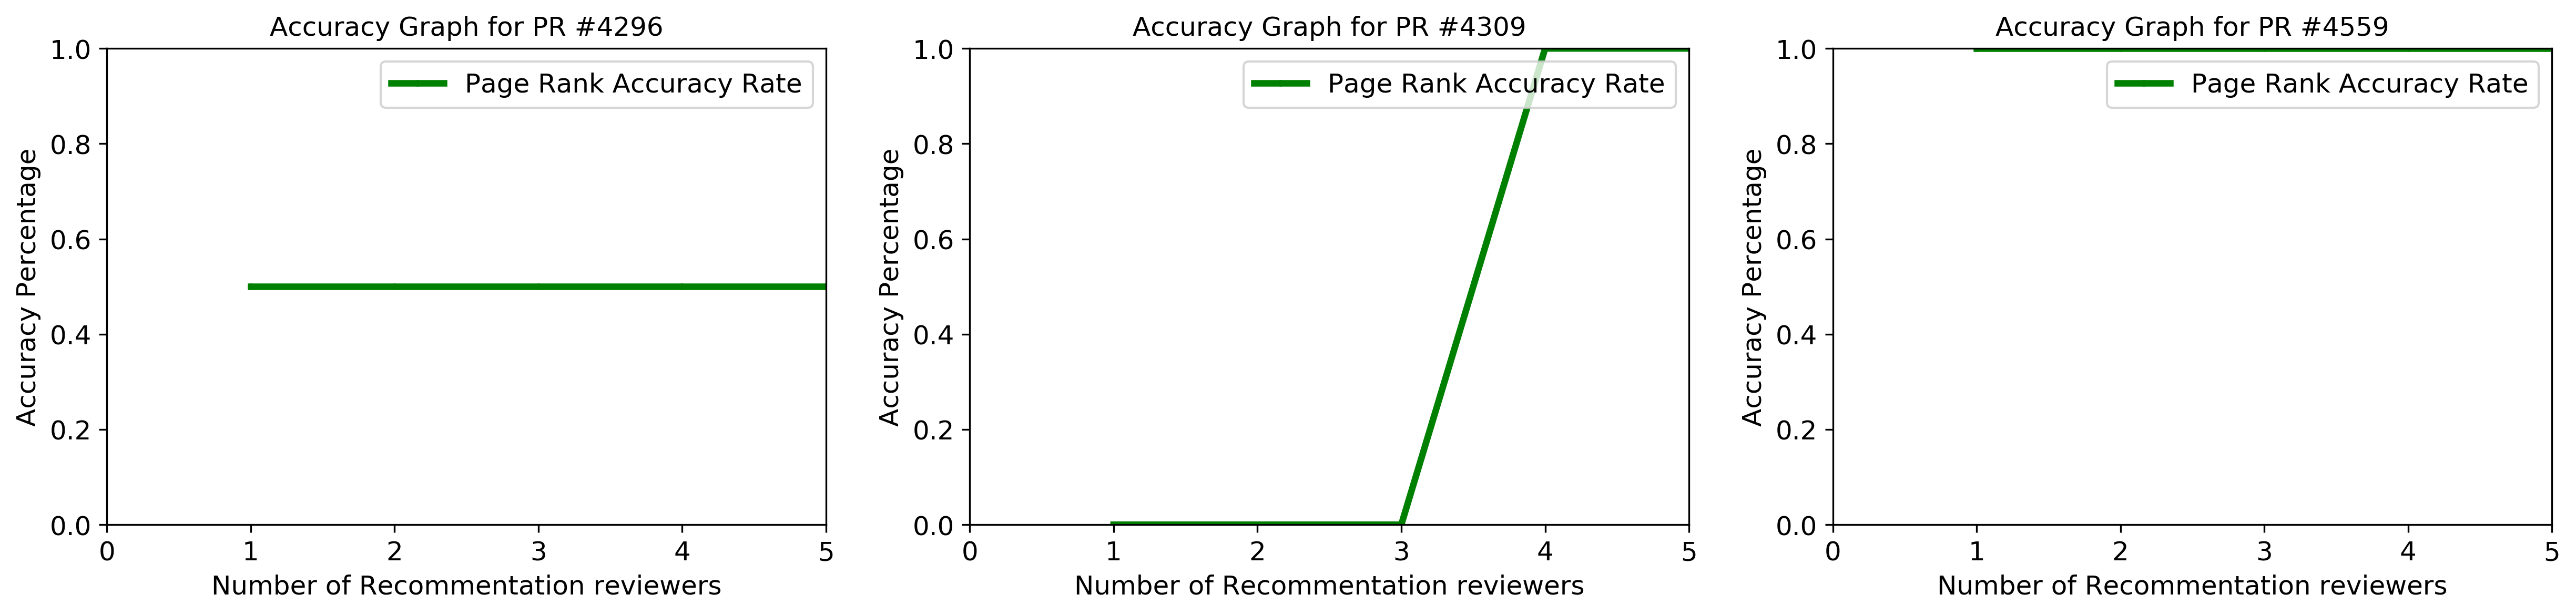

In [24]:
truncated_pr_metrices = pr_metrices[:3]

plt.rcParams.update({'font.size': 12, 'axes.titlesize': 12})
fig, axs = plt.subplots(1, len(truncated_pr_metrices), figsize=(20, 4), dpi=300)

for i in range(0, len(truncated_pr_metrices)):
    
    # Plot the accuracy metrices
    axs[i].plot(range(1, 6), pr_metrices[i], label="Page Rank Accuracy Rate", color='green', marker='o',
             linewidth=3, markersize=2)
    
    # Set plot attributes
    axs[i].set_ylabel("Accuracy Percentage")
    axs[i].set_xlabel("Number of Recommentation reviewers")
    axs[i].set_title("Accuracy Graph for PR #{}".format(open_pull_requests[i][0]))
    axs[i].set_ylim(0, 1)
    axs[i].set_xlim(1, 5)
    axs[i].set_yticks(np.arange(0, 1.2, step=0.2))
    axs[i].set_xticks(np.arange(6))
    
    # show legend
    axs[i].legend()

figname = 'recomm_plot'
plt.savefig(figname+'.png', bbox_inches='tight', dpi=500)
plt.show()

## Step 17

Get the average accuracy of recommendation

In [25]:
avg_pr = []
for x in range(0, 5):
    sum_pg = 0
    for y in range(0, 3):
        sum_pg += pr_metrices[y][x]
    sum_pg = sum_pg / 3
    avg_pr.append(sum_pg)
print(avg_pr)

[0.5, 0.5, 0.5, 0.8333333333333334, 0.8333333333333334]
